##  In this notebook we build different kinds of quantum trajectories. We will be primairly interested in:

1. Kerr in qubit regime

2. Kerr in bistable regime

3. Atom bistability (see notebook "make_quantum_trajectories-absorptive_bistability").

We will also be interested in the transition between the first and second regimes of the Kerr system.

I store trajectory files as *.pkl files or *.mat files. This way I can easily load them into another notebook, or load the trajectories to matlab.

In [1]:
## Some of the code seems to require Python 3

import sys
sys.version

'3.4.4 |Continuum Analytics, Inc.| (default, Jun 15 2016, 15:48:32) \n[GCC 4.2.1 Compatible Apple LLVM 4.2 (clang-425.0.28)]'

In [2]:
import os
directory_name = "/trajectory_data"
d = os.path.dirname(directory_name)

try:
    os.stat(d)
except:
    os.mkdir(d) 

In [3]:
####
####

### Select Regime from "kerr_qubit", "kerr_bistable", "intermediate_state"
### TODO: implement a regime "transition_kerr" which increases the drive periodically, or stochastically, etc.

Regime = "kerr_qubit"

####

### Which file formats to save trajectory data.
### Name of the file to save. The extension will be .mat for matlab and .pkl for pickle.

## matlab file.
save_mat = True
## pkl file (can be loaded in python) in the same format as above.
save_pkl = True

file_name = "." + directory_name + '/' + Regime

####
####

In [4]:
import matplotlib as mil
mil.use('TkAgg')


In [5]:
## QHDL package
from qnet.algebra.circuit_algebra import *
from qnet.circuit_components.displace_cc import Displace
from sympy import sqrt


## qutip 
import qutip as qt

## numpy
import numpy as np

## plotting
%matplotlib inline
import matplotlib.pyplot as plt

## pickle
import pickle

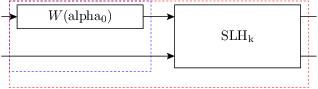

100.0%. Run time: 144.33s. Est. time left: 00:00:00:00
Total run time: 144.48s


In [10]:
# Define Kerr parameters
chi = symbols("chi", real=True, positive=True)
Delta = symbols("Delta", real=True)
kappa_1, kappa_2 = symbols("kappa_1, kappa_2", real=True, positive=True)
alpha0 = symbols("alpha_0")

## qubit regime
params = {alpha0 : 10.0, chi : -100, Delta : 0., kappa_1 : 0.5, kappa_2 : 0,
          'Ntraj' : 1, 'duration' : 100000., 'Nfock' : 15}
    
## These are used later in the simulation
Ntraj = params['Ntraj']
duration = params['duration']
Nfock = params['Nfock']


# Construct Kerr SLH
a_k = Destroy("k")
S = -identity_matrix(2)
L = [sqrt(kappa_1)*a_k, sqrt(kappa_2)*a_k]
H = Delta*a_k.dag()*a_k + chi/2*a_k.dag()*a_k.dag()*a_k*a_k
KERR = SLH(S, L, H).toSLH()

# Add coherent drive
SYS = KERR << Displace(alpha=alpha0)+cid(1)
SYS.show()
SYS = SYS.toSLH()

SYS_num = SYS.substitute(params)

SYS_num.space.dimension = Nfock
psi0 = qt.coherent(Nfock, 0)
Tsim = np.arange(0, duration/1000, 1e-3)

H_num, L_num = SYS_num.HL_to_qutip()

## Observables

obs = [a_k.dag()*a_k, a_k+a_k.dag(), (a_k-a_k.dag())/1j]
obsq = [o.to_qutip(full_space = SYS_num.space) for o in obs]

## generate trajectory
mcdata = qt.mcsolve(H_num, psi0, Tsim, L_num, 
                       obsq, ntraj=Ntraj, 
                       options=qt.Odeoptions(store_states=True,average_expect=False))



In [11]:
SYS

SLH(Matrix([[-1, 0], [0, -1]]), Matrix([[OperatorPlus(ScalarTimesOperator(-alpha_0, IdentityOperator), ScalarTimesOperator(sqrt(kappa_1), Destroy(LocalSpace('k', ''))))], [ScalarTimesOperator(sqrt(kappa_2), Destroy(LocalSpace('k', '')))]]), OperatorPlus(ScalarTimesOperator(I/2, OperatorPlus(ScalarTimesOperator(alpha_0*sqrt(kappa_1), Create(LocalSpace('k', ''))), ScalarTimesOperator(-sqrt(kappa_1)*conjugate(alpha_0), Destroy(LocalSpace('k', ''))))), ScalarTimesOperator(chi/2, OperatorTimes(Create(LocalSpace('k', '')), Create(LocalSpace('k', '')), Destroy(LocalSpace('k', '')), Destroy(LocalSpace('k', '')))), ScalarTimesOperator(Delta, OperatorTimes(Create(LocalSpace('k', '')), Destroy(LocalSpace('k', ''))))))

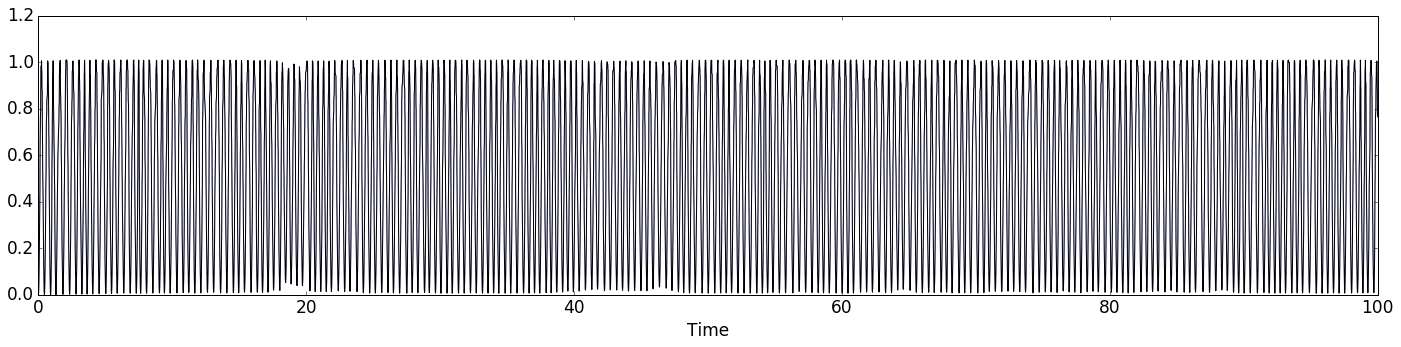

In [12]:
N_num = qt.num(Nfock)

a = qt.destroy(Nfock)
E = a+a.dag()

f, a = plt.subplots(figsize=(24,5))
plt.xlabel("Time", fontsize=17);# plt.ylabel("Photon Number", fontsize=17)
plt.tick_params(labelsize=17)


for i in range(Ntraj): 
    a.plot(mcdata.times[0:int(duration)], qt.expect(N_num, mcdata.states[i])[0:int(duration)], "b", alpha=0.3)

a.plot(mcdata.times[0:int(duration)],
       np.average(np.asarray([qt.expect(N_num, mcdata.states[i])[0:int(duration)] for i in range(Ntraj)]),axis = 0),
       c='black'
      )


In [13]:
## save as matlab or pkl file

from mcdata2matfile_or_pkl import mcdata2matfile_or_pkl

if save_mat:
    mcdata2matfile_or_pkl(mcdata, file_name, obs, save_mat = True, save_pkl = False,)    
if save_pkl:
    mcdata2matfile_or_pkl(mcdata, file_name, obs, save_mat = False, save_pkl = True, params = params)

/Users/gil/Documents/repos/diffusion_maps/make_quantum_jump_trajectories/trajectory_data/kerr_qubit.mat

/Users/gil/Documents/repos/diffusion_maps/make_quantum_jump_trajectories/trajectory_data/kerr_qubit.pkl